<a href="https://colab.research.google.com/github/bxxham/cat-3-data-science/blob/main/cat_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 LOGISTIC REGRESSION RESULTS: 
Accuracy: 0.996
Precision: 0.9973297730307076
Recall: 0.9986631016042781
ROC AUC: 0.3997326203208556

 GRADIENT BOOSTING RESULTS (BEST): 
Accuracy: 0.996
Precision: 0.9973297730307076
Recall: 0.9986631016042781
ROC AUC: 0.5113636363636364
Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__n_estimators': 80}


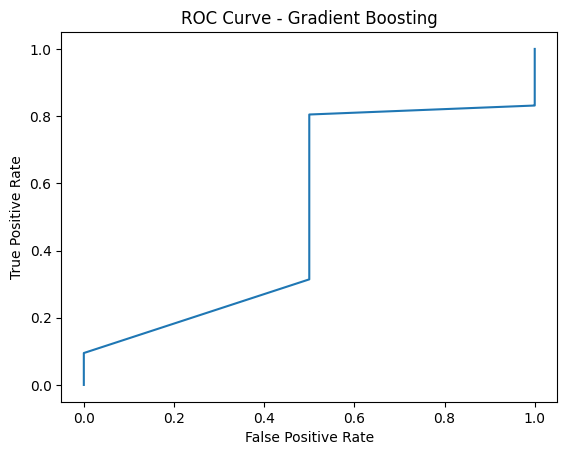

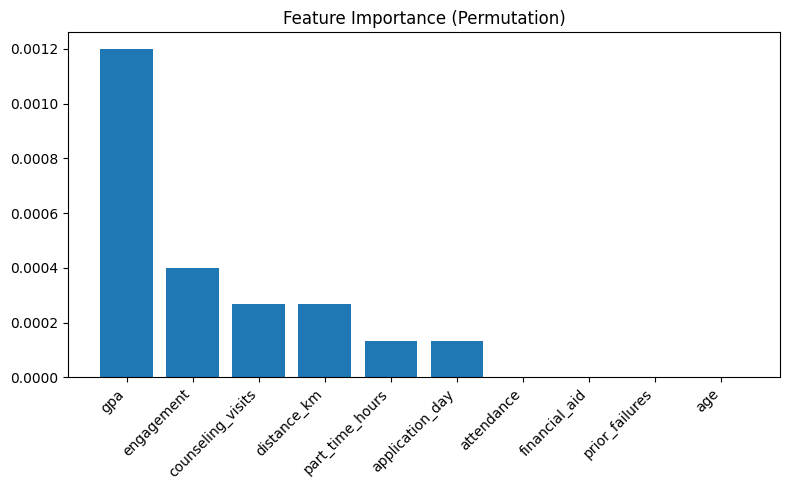

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import joblib



rng = np.random.default_rng(42)
n = 3000

gpa = np.clip(rng.normal(2.8, 0.6, size=n), 0, 4)
attendance = np.clip(rng.normal(0.85, 0.12, size=n), 0, 1)
financial_aid = rng.binomial(1, 0.35, size=n)
distance_km = np.clip(rng.exponential(5, size=n), 0, 200)

application_day = rng.integers(0, 120, size=n)
prior_failures = rng.poisson(0.3, size=n)
engagement = np.clip(rng.normal(0.5, 0.2, size=n), 0, 1)
age = rng.integers(17, 45, size=n)

df = pd.DataFrame({
    "gpa": gpa,
    "attendance": attendance,
    "financial_aid": financial_aid,
    "distance_km": distance_km,
    "application_day": application_day,
    "prior_failures": prior_failures,
    "engagement": engagement,
    "age": age,
    "part_time_hours": part_time_hours,
    "counseling_visits": counseling_visits,
})



logits = (
    1.5 * gpa
    + 1.2 * attendance
    + 0.8 * financial_aid
    - 0.03 * distance_km
    + 0.01 * application_day
    - 0.6 * prior_failures
    + 1.4 * engagement
    - 0.02 * part_time_hours
)

prob = 1 / (1 + np.exp(-logits))
df["enrolled"] = rng.binomial(1, prob)

X = df.drop("enrolled", axis=1)
y = df["enrolled"]



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

num_features = X.columns.tolist()

preprocess = ColumnTransformer([
    ("scale", StandardScaler(), num_features)
])



log_reg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500))
])

log_reg.fit(X_train, y_train)
proba_lr = log_reg.predict_proba(X_test)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

print("\n LOGISTIC REGRESSION RESULTS: ")
print("Accuracy:", accuracy_score(y_test, pred_lr))
print("Precision:", precision_score(y_test, pred_lr))
print("Recall:", recall_score(y_test, pred_lr))
print("ROC AUC:", roc_auc_score(y_test, proba_lr))



gb = Pipeline([
    ("prep", preprocess),
    ("clf", GradientBoostingClassifier())
])

param_grid = {
    "clf__n_estimators": [80, 120],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [2, 3]
}

grid = GridSearchCV(gb, param_grid, cv=3, scoring="roc_auc", n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
proba_gb = best_model.predict_proba(X_test)[:, 1]
pred_gb = (proba_gb >= 0.5).astype(int)

print("\n GRADIENT BOOSTING RESULTS (BEST): ")
print("Accuracy:", accuracy_score(y_test, pred_gb))
print("Precision:", precision_score(y_test, pred_gb))
print("Recall:", recall_score(y_test, pred_gb))
print("ROC AUC:", roc_auc_score(y_test, proba_gb))
print("Best Params:", grid.best_params_)



fpr, tpr, _ = roc_curve(y_test, proba_gb)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.savefig("roc_curve.png", dpi=150)
plt.show()
plt.close()



result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42
)

importances = pd.DataFrame({
    "feature": num_features,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(importances["feature"], importances["importance"])
plt.xticks(rotation=45, ha="right")
plt.title("Feature Importance (Permutation)")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150)
plt.show()
plt.close()



joblib.dump(best_model, "enrollment_model_gb.pkl")



pred_df = X_test.copy()
pred_df["actual"] = y_test
pred_df["predicted_prob"] = proba_gb
pred_df["predicted_label"] = pred_gb

pred_df.to_csv("enrollment_test_predictions.csv", index=False)